# W207 Final Project : Facial Keypoint Detection 
# Team: Joanie Weaver, Sandip Panesar, Jackie Nichols, Rakesh Walisheter
W207 Tuesday @4pm

ref: https://www.kaggle.com/c/facial-keypoints-detection

In [15]:
cd /content/drive/My Drive/w207/blackboxes/utils

/content/drive/My Drive/w207/blackboxes/utils


# Data Cleaning File

## Setup
Imports, reading in files, etc..

In [16]:
#Set the utils path to point to the utils directory locally
UTILS_PATH = "utils"

import os, sys
sys.path.append(UTILS_PATH)
import transform_data
from transform_data import TransformData

import pandas as pd
import numpy as np
import os
import warnings

from tqdm import tqdm
import zlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
from matplotlib.ticker import PercentFormatter
import pickle
import imp


In [17]:
def load_train_pickle():
    train = pickle.load( open( "../data/train.p", "rb" ) )
    train.rename(columns = {'level_0' : 'index'}, inplace = True)
    return train

def load_train_dup_pickle():
    train_duplicates = pickle.load( open("../data/traindup.p", "rb"))
    train_duplicates.set_index('index', inplace=True, drop=False)
    return train_duplicates

In [18]:
#Load the pickle files

train = pickle.load( open( "../data/train.p", "rb" ) )
test = pickle.load( open("../data/test.p", "rb"))

train.rename(columns = {'level_0' : 'index'}, inplace = True)

train_duplicates = pickle.load( open("../data/traindup.p", "rb"))
test_duplicates = pickle.load( open("../data/testdup.p", "rb"))

train_duplicates.set_index('index', inplace=True, drop=False)
print("Test shape is: ", test.shape)
print("Train shape is: ", train.shape)

print("Test duplicates shape is: ", test_duplicates.shape)
print("Train duplicates shape is: ", train_duplicates.shape)


Test shape is:  (1783, 4)
Train shape is:  (7049, 33)
Test duplicates shape is:  (60, 3)
Train duplicates shape is:  (1098, 3)


In [19]:
#HELPER FUNCTIONS to reset the train and test dataframes

def reset_train_df():
    #train = df['train'].reset_index().copy()
    new_train = train.reset_index().copy()
    #Get the images and perform a checksum on every image in train: https://www.geeksforgeeks.org/zlib-adler32-in-python/
    new_train['check_sum'] = train.image.map(lambda x: zlib.adler32(x))
    new_train.pop('level_0')
    return new_train

def reset_test_df():
    #test = df['test'].reset_index().copy()
    new_test = test.reset_index().copy()
    #Get the images and perform a checksum on every image in train: https://www.geeksforgeeks.org/zlib-adler32-in-python/
    new_test['check_sum'] = test.image.map(lambda x: zlib.adler32(x))
    new_test.pop('level_0')
    return new_test

def get_coordinate_columns():
    coordinates = [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]
    return coordinates

In [20]:
#Creating a copy of the train data in train_data in case you want to add columns back in from df[train]
train_data=train.copy(deep=True)
train_data

,index,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,image,check_sum
0,0,66.033562,39.002274,30.227007,36.421677,59.582077,39.647423,73.130348,39.969997,36.356571,37.389400,23.452871,37.389400,56.953262,29.033648,80.227127,32.228138,40.227608,29.002321,16.356379,29.647470,44.420570,57.066803,61.195309,79.970169,28.614496,77.388992,43.312603,72.935455,43.130707,84.485771,"[238, 236, 237, 238, 240, 240, 239, 241, 241, ...",3990298755
1,1,64.332939,34.970078,29.949276,33.448715,58.856171,35.274349,70.722725,36.187164,36.034725,34.361530,24.472511,33.144444,53.987404,28.275949,78.634216,30.405924,42.728851,26.146042,16.865362,27.058859,48.206299,55.660934,56.421448,76.351997,35.122383,76.047661,46.684597,70.266556,45.467915,85.480171,"[219, 215, 204, 196, 204, 211, 212, 200, 180, ...",1359000491
2,2,65.057053,34.909641,30.903790,34.909641,59.411999,36.320969,70.984421,36.320969,37.678104,36.320969,24.976421,36.603222,55.742527,27.570948,78.887367,32.651623,42.193893,28.135452,16.791159,32.087116,47.557262,53.538948,60.822948,73.014313,33.726315,72.732002,47.274948,70.191788,47.274948,78.659370,"[144, 142, 159, 180, 188, 188, 184, 180, 167, ...",3822334647
3,3,65.225739,37.261772,32.023094,37.261772,60.003338,39.127178,72.314713,38.380966,37.618645,38.754116,25.307270,38.007904,56.433807,30.929865,77.910263,31.665726,41.671513,31.049990,20.458017,29.909342,51.885078,54.166538,65.598885,72.703720,37.245495,74.195480,50.303165,70.091690,51.561184,78.268379,"[193, 192, 193, 194, 194, 194, 193, 192, 168, ...",3001797594
4,4,66.725304,39.621262,32.244808,38.042030,58.565891,39.621262,72.515930,39.884468,36.982380,39.094852,22.506111,38.305237,57.249569,30.672176,77.762947,31.737247,38.035435,30.935381,15.925870,30.672176,43.299534,64.889519,60.671410,77.523239,31.191755,76.997299,44.962749,73.707390,44.227142,86.871162,"[147, 148, 160, 196, 215, 214, 216, 217, 219, ...",2161940314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,7044,67.402550,31.842550,29.746750,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.265961,67.029091,NaN,NaN,NaN,NaN,NaN,NaN,50.426636,79.683922,"[71, 74, 85, 105, 116, 128, 139, 150, 170, 187...",585994373
7045,7045,66.134399,38.365501,30.478626,39.950199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.910347,66.626015,NaN,NaN,NaN,NaN,NaN,NaN,50.287395,77.983025,"[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, 5...",191806966
7046,7046,66.690735,36.845222,31.666420,39.685043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.462570,67.515160,NaN,NaN,NaN,NaN,NaN,NaN,49.462570,78.117119,"[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, 7...",3036254932
7047,7047,70.965080,39.853664,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.754204,66.724991,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586449,"[254, 254, 254, 254, 254, 238, 193, 145, 121, ...",260257816


## Outlier Identification
As we saw in the EDA, there are a variety of types of images with a variety of keypoints. Below, we will remove some of the images we saw as outliers in the EDA.

Outlier types:
- Mislabelled images
- Weird/bad images
- All outliers (i.e. images that contain keypoints that are greater than 3 standard deviations away from the mean for that keypoint)

In [21]:
#CODE CELL FOR JOANIE

#This block is identifying and counting all outliers
#Outliers are images that contain keypoints > 3std from mean
def find_outliers():
    train=train_data.drop(["image"],axis=1)
    described_train=train.describe().T
    std=described_train["std"]
    mean=described_train["mean"]
    q1=described_train["25%"]
    q3=described_train["75%"]
    iqr=q3-q1

    #If we define outliers using IQR
    #outlier_low=q1-1.5*iqr
    #outlier_high=q3+1.5*iqr

    #If we define outliers using std
    outlier_low=mean-3*std
    outlier_high=mean+3*std



    #Keep track of these images in a list
    outlier_images=[]
    outlier_dict={}

    #Iterate through the data to find outliers based on whether they are lower/higher than defined outlier boundaries
    for col in train.columns:
        indices=list(np.where((train[col] < outlier_low[col]) | (train[col] > outlier_high[col]))[0])
        outlier_images.extend(indices)
        for i in indices:
            temp=outlier_dict.get(i,[])
            temp.append(col[:-1])
            outlier_dict[i]=temp

    #Only count each index once
    outliers=np.unique(outlier_images)
    outliers
    print("Finding points 3 standard deviations away from the mean results in ",len(outliers),
        "images being classified as outliers")
    print("This represents",len(outliers)/train.shape[0]*100,"% of our total data")

    #print(train.shape)
    
    return outliers




In [22]:
#CODE CELL FOR JOANIE

#This function is removing the worst outliers
#The worst outliers are the mislabelled images and the weird/bad images
def drop_worst_outliers():

    print("Before dropping worst outliers train shape is: ", train.shape)
    print("Before dropping worst outliers train duplicates shape is: ", train_duplicates.shape)
    miss_labelled = [1747, 1877, 1907,2199] #These are the images with keypoints that are not right
    bad_images = [6492,6493,2430,3697] #These are the two collages and the two cartoons

    worst_outliers = miss_labelled + bad_images

    #Drop with inplace drops inplace
    #train_data.drop(index=worst_outliers,inplace=True)
    train.drop(index=worst_outliers,inplace=True,errors='ignore')
    train_duplicates.drop(index=worst_outliers,inplace=True,errors='ignore')
    print("After dropping worst outliers train shape is: ", train.shape)
    print("After dropping worst outliers train duplicates shape is: ", train_duplicates.shape)

#This function is for removing all outliers as defined above
def drop_all_outliers():
    print("Before dropping all outliers train shape is: ", train.shape)
    print("Before dropping all outliers train duplicates shape is: ", train_duplicates.shape)
    
    outliers = find_outliers()
    overlap = [bad for bad in outliers if bad in train_duplicates.index]

    train.drop(index=outliers,inplace=True, errors='ignore')
    #Drop the overlap outliers and duplicates
    train_duplicates.drop(index=overlap,inplace=True,errors='ignore')
    print("After dropping all outliers train shape is: ", train.shape)
    print("After dropping all outliers train duplicates shape is: ", train_duplicates.shape)

def drop_overlap_outliers():
    print("Before dropping overlap outliers train shape is: ", train.shape)
    print("Before dropping overlap outliers train duplicates shape is: ", train_duplicates.shape)
    
    outliers = find_outliers()
    overlap = [bad for bad in outliers if bad in train_duplicates.index]

    print("There are", len( overlap), " images that are outliers that appear in train duplicates")
    
    train.drop(index=overlap,inplace=True, errors='ignore')
    #Drop the overlap outliers and duplicates
    train_duplicates.drop(index=overlap,inplace=True,errors='ignore')
    print("After dropping overlap outliers train shape is: ", train.shape)
    print("After dropping overlap outliers train duplicates shape is: ", train_duplicates.shape)




## Helper Code for Duplicate Data in Train and Test datasets

In [23]:
#CODE CELL FOR JACKIE
# Remove duplicates in the train dataset by taking the mean of all values for that image in each label 
def remove_train_duplicates( train_duplicates,verbose=True):
    # First let's reset the index since we've been working on the df 
        
    train = reset_train_df()
    #train_duplicates.reset_index()

    #Get all of the coordinates
    coordinates = get_coordinate_columns()

    #Create an empty df with the coordinate columns in place
    final_images = train[(train.index == -1)][coordinates].copy()
    final_check_sum = train_duplicates.check_sum.unique()

    #For each unique check_sum in duplicates...
    for check_sum in train_duplicates.check_sum.unique():
        #Get all of the duplicates with the same check_sum
        duplicates = train_duplicates[(train_duplicates.check_sum == check_sum)]['index'].values
        
        #Get the first image that appears in the train dataset with this check_sum
        image = train[(train['index'].isin(duplicates))].image.values[0]
        #Take the mean of all the coordinate columns - this is what we will use for the final single image
        fixed = pd.DataFrame(pd.DataFrame(train[(train['index'].isin(duplicates))], columns=coordinates).mean(axis = 0)).T
        #Make sure to include the actual image (lol)
        fixed['image'] = [image]
        fixed['check_sum'] = check_sum
        fixed['index'] = duplicates[0] #take first index
        
        #Append it to the list of final_images
        final_images = final_images.append(fixed, ignore_index = True)
        
            
    #For reporting purposes: 
    if verbose: 
        print("="*13 + "Train" + "="*13)
    if verbose: 
        print(f"Before delete:     {train.shape}")

    #Remove the duplicates from train - danger, danger, must replace them
    train = train[~(train['index'].isin(train_duplicates['index'].values))]
    if verbose: 
        print(f"After  delete:     {train.shape}")

    #Dump the final images that were duplicates so we can take a look at them after the processing. 
    pickle.dump(final_check_sum, open( "../data/final_check_sum.p", "wb" ) )
 

    #Replace removed duplicates with final_images
    train = train.append(final_images, ignore_index = True).reset_index()
    train['check_sum'] = train.image.map(lambda x: zlib.adler32(x))
    #train.drop(columns=['index'], inplace = True)
    if verbose: 
        print(f"After  append:     {train.shape}")
    return train



In [24]:
#CODE CELL FOR JACKIE
##########Test Data set

#Now do the same for test, this will be easier since we don't need
#to deal with points and taking the mean
def remove_test_duplicates(verbose=True):
#We can do this differently since we don't need to take the mean. 
#Go through the test and only add items to the final test image if
#we do not already have the check_sum. If we find the check_sum, don't
#add it it's a duplicate. 
    test = reset_test_df()
    if verbose: print("="*13 + "Test=" + "="*13)
    if verbose: print(f"Before delete:     {test.shape}")
    test = reset_test_df()
    #Create an empty df with the coordinate columns in place
    final_test_images = test[(test.index == -1)]
    
    for test_index, check_sum in zip(test['index'], test.check_sum):
        if not (check_sum in list(final_test_images.check_sum.values)):
            final_test_images = final_test_images.append(test.loc[(test['index'] == test_index)], ignore_index = True)
    
    if verbose: print(f"After  delete:     {final_test_images.shape}")
    return final_test_images


## Add Flipped images into the training set

In [25]:
def add_horiz_flips(train):
    data_transform = transform_data.TransformData(verbose=True)
    flipped = data_transform.FlipHorizontal(train)
    new_train = train.append(flipped)
    return new_train

In [26]:
train = load_train_pickle()
print(train.shape)
train_with_flipped = add_horiz_flips(train)
print(train_with_flipped.shape)

(7049, 33)
(9189, 33)


## PICKLE DIFFERENT VERSIONS OF TRAIN CLEANED
In order for this to work you will need to reload the orginal pickle files. 


In [27]:
#Run this if you would like to include horizontally flipped images with all the keypoints in the training set
train = load_train_pickle()
train_with_flipped = add_horiz_flips(train)
train = train_with_flipped.copy()

In [28]:
#PICKLE 1A: OVERLAP OUTLIERS
#only drop the overlap outliers for now
#use original train data
train = load_train_pickle()
train_data=train.copy(deep=True)
drop_overlap_outliers()
pickle.dump( train, open( "../cleantrain/clean_o_outliers.p", "wb" ) )

train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain_8/clean_o_outliers.p", "wb" ) )


Before dropping overlap outliers train shape is:  (7049, 33)
Before dropping overlap outliers train duplicates shape is:  (1098, 3)
Finding points 3 standard deviations away from the mean results in  409 images being classified as outliers
This represents 5.802241452688325 % of our total data
There are 29  images that are outliers that appear in train duplicates
After dropping overlap outliers train shape is:  (7020, 33)
After dropping overlap outliers train duplicates shape is:  (1069, 3)


In [29]:
#CODE CELL FOR JACKIE
#PICKLE 2A: WORST OUTLIERS
#use original train data
train = load_train_pickle()
train_data=train.copy(deep=True)
drop_worst_outliers()
#Pickle train so that we can jump in with cleaning this data
pickle.dump( train, open( "../cleantrain/clean_w_outliers.p", "wb" ) )

train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain_8/clean_w_outliers.p", "wb" ) )

Before dropping worst outliers train shape is:  (7049, 33)
Before dropping worst outliers train duplicates shape is:  (1069, 3)
After dropping worst outliers train shape is:  (7041, 33)
After dropping worst outliers train duplicates shape is:  (1069, 3)


In [30]:
#PICKLE 3A: ALL OUTLIERS
train = load_train_pickle()
train_data=train.copy(deep=True)
drop_overlap_outliers()
drop_worst_outliers()
pickle.dump( train, open( "../cleantrain/clean_all_outliers.p", "wb" ) )

train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain_8/clean_all_outliers.p", "wb" ) )

Before dropping overlap outliers train shape is:  (7049, 33)
Before dropping overlap outliers train duplicates shape is:  (1069, 3)
Finding points 3 standard deviations away from the mean results in  409 images being classified as outliers
This represents 5.802241452688325 % of our total data
There are 0  images that are outliers that appear in train duplicates
After dropping overlap outliers train shape is:  (7049, 33)
After dropping overlap outliers train duplicates shape is:  (1069, 3)
Before dropping worst outliers train shape is:  (7049, 33)
Before dropping worst outliers train duplicates shape is:  (1069, 3)
After dropping worst outliers train shape is:  (7041, 33)
After dropping worst outliers train duplicates shape is:  (1069, 3)


## MORE PICKLES WITH duplicates

In [31]:
#CODE CELL FOR JACKIE
#PICKLE 4: DUPLICATES ONLY
#Only run this cell to get clean_duplicates
print("Applying EDA fix for duplicates")
print()
train = load_train_pickle()
train_duplicates = load_train_dup_pickle()
train_data=train.copy(deep=True)
train = remove_train_duplicates(train_duplicates)
pickle.dump( train, open( "../cleantrain/clean_duplicates.p", "wb" ) )
print()
test = remove_test_duplicates()

train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain_8/clean_duplicates.p", "wb" ) )



Applying EDA fix for duplicates

=============Train=============
Before delete:     (7049, 33)
After  delete:     (5951, 33)
After  append:     (6494, 34)

=============Test==============
Before delete:     (1783, 4)
After  delete:     (1752, 4)


In [32]:
#CODE CELL FOR JACKIE
#PICKLE 5: OVERLAP OUTLIERS + DUPLICATES
#Overlap outliers + duplicates
train = load_train_pickle()
train_duplicates = load_train_dup_pickle()
train_data=train.copy(deep=True)
drop_overlap_outliers()
train = remove_train_duplicates(train_duplicates)
pickle.dump( train, open( "../cleantrain/clean_o_dups.p", "wb" ) )

train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain_8/clean_o_dups.p", "wb" ) )

Before dropping overlap outliers train shape is:  (7049, 33)
Before dropping overlap outliers train duplicates shape is:  (1098, 3)
Finding points 3 standard deviations away from the mean results in  409 images being classified as outliers
This represents 5.802241452688325 % of our total data
There are 29  images that are outliers that appear in train duplicates
After dropping overlap outliers train shape is:  (7020, 33)
After dropping overlap outliers train duplicates shape is:  (1069, 3)
=============Train=============
Before delete:     (7020, 33)
After  delete:     (5951, 33)
After  append:     (6483, 34)


In [33]:
#PICKLE 6: WORST OUTLIERS + DUPLICATES
# Worst + DUPS
train = load_train_pickle()
train_duplicates = load_train_dup_pickle()
train_data=train.copy(deep=True)
drop_worst_outliers()
train = remove_train_duplicates(train_duplicates)
pickle.dump( train, open( "../cleantrain/clean_w_dups.p", "wb" ) )

train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain_8/clean_w_dups.p", "wb" ) )

Before dropping worst outliers train shape is:  (7049, 33)
Before dropping worst outliers train duplicates shape is:  (1098, 3)
After dropping worst outliers train shape is:  (7041, 33)
After dropping worst outliers train duplicates shape is:  (1095, 3)
=============Train=============
Before delete:     (7041, 33)
After  delete:     (5946, 33)
After  append:     (6488, 34)


In [34]:
#PICKLE 7: OVERLAP + WORST OUTLIERS + DUPLICATES
#Overlap outliers + duplicates
train = load_train_pickle()
train_duplicates = load_train_dup_pickle()
train_data=train.copy(deep=True)
drop_overlap_outliers()
drop_worst_outliers()
train = remove_train_duplicates(train_duplicates)
pickle.dump( train, open( "../cleantrain/clean_wo_dups.p", "wb" ) )

train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain_8/clean_wo_dups.p", "wb" ) )

Before dropping overlap outliers train shape is:  (7049, 33)
Before dropping overlap outliers train duplicates shape is:  (1098, 3)
Finding points 3 standard deviations away from the mean results in  409 images being classified as outliers
This represents 5.802241452688325 % of our total data
There are 29  images that are outliers that appear in train duplicates
After dropping overlap outliers train shape is:  (7020, 33)
After dropping overlap outliers train duplicates shape is:  (1069, 3)
Before dropping worst outliers train shape is:  (7020, 33)
Before dropping worst outliers train duplicates shape is:  (1069, 3)
After dropping worst outliers train shape is:  (7015, 33)
After dropping worst outliers train duplicates shape is:  (1069, 3)
=============Train=============
Before delete:     (7015, 33)
After  delete:     (5946, 33)
After  append:     (6478, 34)


## VIEW SOME IMAGES WITH MEAN APPLIED AFTER DUPLICATE REMOVAL

In [37]:

#Load the fixed images from the duplication process
fixed_images = pickle.load( open( "../data/final_check_sum.p", "rb" ) )

In [38]:
#Print clean images:

def show_fixed_images(fixed_images):
    ## TRAIN 
    # Let's view some of these duplicated train images
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Sample of Cleaned Duplicate images from the Train dataset\n n= 50', size = 20,  y = 1.04, weight = 'bold')
    #Get the point coordinates for example: mouth_center_top_lip_x
    coordinates = get_coordinate_columns()
    #print(coordinates)
    
   
    match_pts = pd.DataFrame(columns =['Points_Found', 'Count'])

     #Loop through and plot each of the 50 images.  
    for i, check_sum in enumerate (fixed_images):
        if i == 50:
            break
        plt.subplot(10,5,i+1)
        img = train[(train['check_sum'] == check_sum)].image.values[0].reshape(96,96)
        #These are the points that have been identified on the images
        points = train[(train['check_sum'] == check_sum)][coordinates].values[0]
        idx = train[(train['check_sum'] == check_sum)]['index']
        plt.imshow(img, cmap = 'gray')
        plt.axis('off')
        matching_pts = 0

        for pts in range(0, 30, 2):
            x_point, y_point = (points[pts], points[pts+1])
            if not (np.isnan(x_point)) and not (np.isnan(y_point)):
                matching_pts += 1
                #Add the point to the plot
                plt.plot(x_point, y_point, 'o', color = "red", markersize = 5)
                

        plt.title("Image #:[%d]\n#Points:[%d]" % (idx, matching_pts))
        if matching_pts in match_pts["Points_Found"].values:
                match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] = match_pts.loc[match_pts['Points_Found'] == matching_pts, 'Count'] + 1
        else:
            match_pts = match_pts.append({'Points_Found':matching_pts,'Count': 1},ignore_index=True)


    #We should save every image with a marker so we can look at them
    #im = Image.fromarray(img)
    #im.save(file_name)

    plt.tight_layout()
    plt.show()





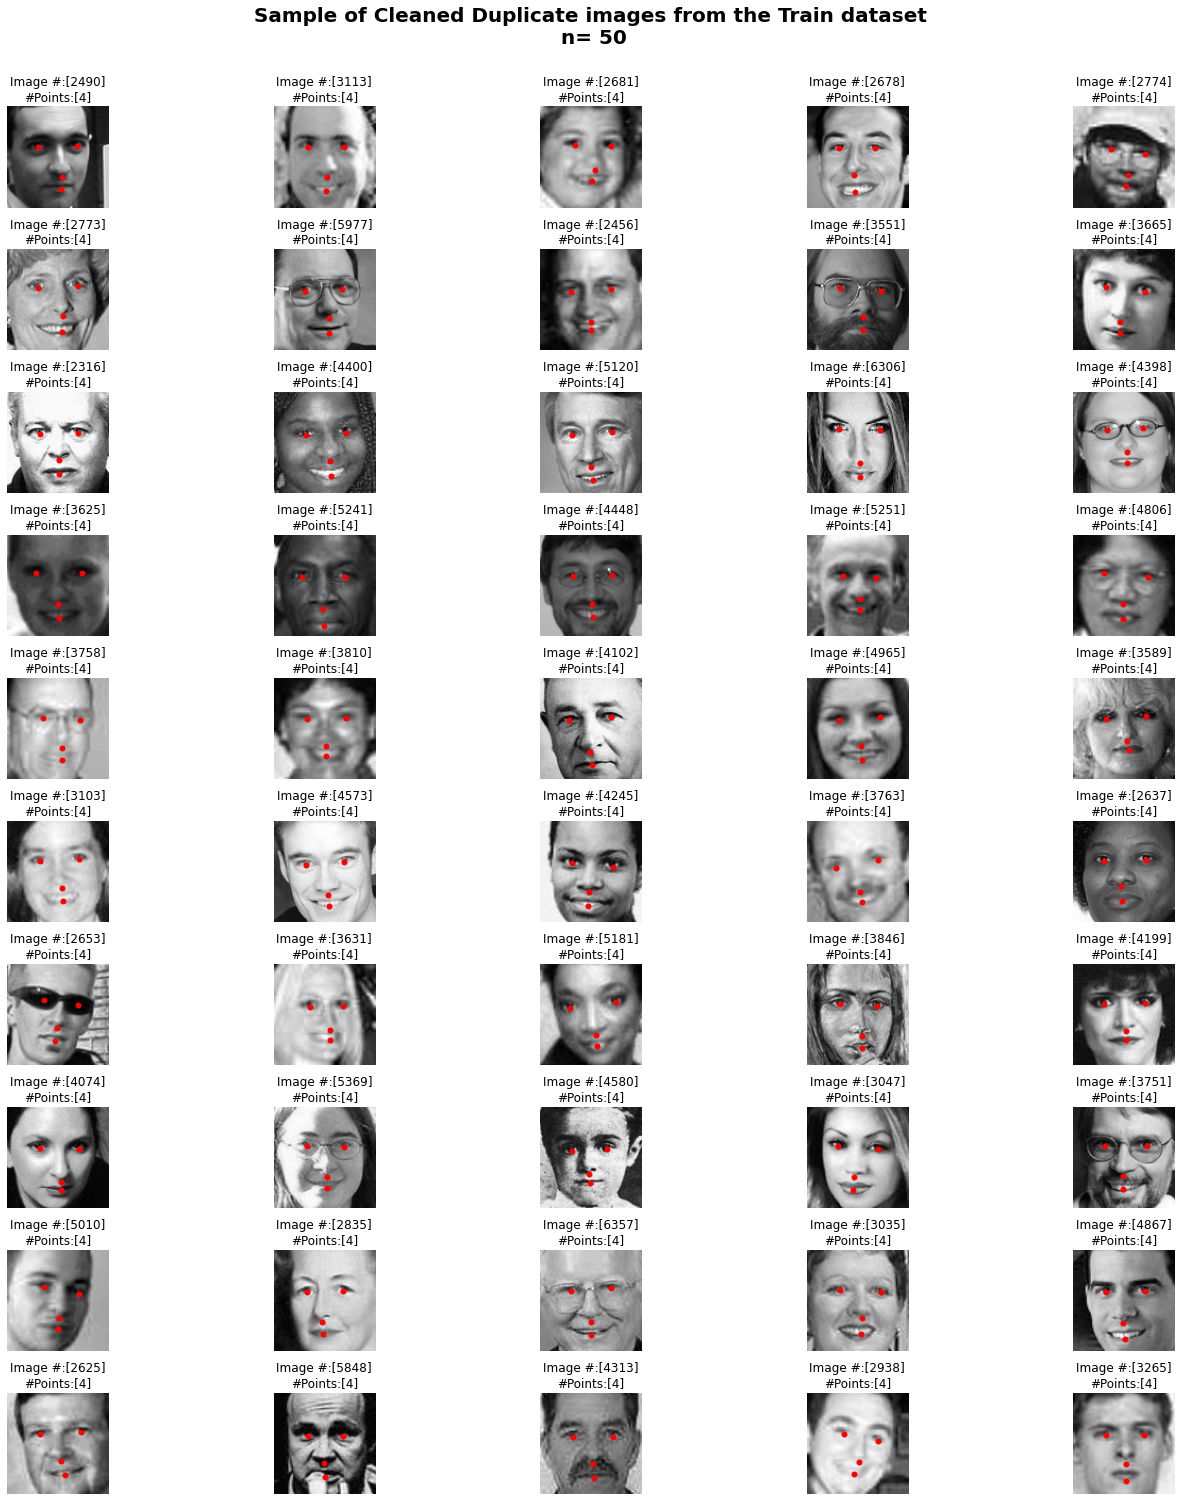

In [39]:
show_fixed_images(fixed_images)

## Load the IDLookup table and pickle it

In [41]:
id_lookup = pd.read_csv("../data/IdLookupTable.csv", names = ['row_id', 'image_id', 'feature_name', 'location'], dtype = {'row_id':'uint16', 'image_id':'uint16', 'location':'float32'}, skiprows = 1)

print("Creating lookup pickle file id_lookup.p")
pickle.dump(id_lookup, open("../data/id_lookup.p", "wb"))
print("Pickle creation complete.")

Creating lookup pickle file id_lookup.p
Pickle creation complete.


### Save 8 key points in train

In [42]:
train = load_train_pickle()
train8 = train[(train.isnull().sum(axis=1) == 22)]
train8_cols = train8.isnull().sum(axis=0).reset_index()[(train8.isnull().sum(axis=0).reset_index()[0] == 0)]['index'].values
train8 = train8[train8_cols]

pickle.dump( train8, open( "../cleantrain/train8.p", "wb" ) )